<a href="https://colab.research.google.com/github/vincelemke99/Bachelor-Thesis/blob/main/lead_predication_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlens --q
!pip install pandas category_encoders scikit-learn


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import machine learning libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer


In [3]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [4]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [5]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [6]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data_raw'

In [7]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [8]:
df.shape

(1451196, 26)

In [9]:
# Identify duplicate lead_ids
duplicate_lead_ids = df[df.duplicated('lead_id', keep=False)]['lead_id'].unique()

# Filter rows to drop
rows_to_drop = df[(df['lead_id'].isin(duplicate_lead_ids)) & (df['is_converted'] == False)]

# Drop rows
# Keep only unique lead_ids (this is optional if the above steps suffice)
df = df.drop_duplicates(subset='lead_id')

In [10]:
df.shape

(238933, 26)

In [11]:
df.head()

,lead_id,domain,name,has_phone,geschlecht,lead_source,lead_quelle_detail,produkt_zeitraum_c,produkt_art_der_ausbildung_c,product_interest_type,...,pagepath,time_OnSite,ManualTerm,Browser,Operating_System,Device,Language,Device_Category,ManualAdContent,bounce
0,00QbG000001B10DUAS,gmail.com,normal,True,weiblich,Internal Referral,hs-fresenius.de,Duales Studium,Bachelor,Infoabend,...,https://www.hs-fresenius.de/termine/anmeldung/...,<NA>,None,None,None,None,None,None,None,None
1,00Q7U00000XGrOYUA1,hotmail.com,normal,True,weiblich,Organisch,Google,Vollzeit,Bachelor,Infoabend,...,https://www.charlotte-fresenius-uni.de/termin-...,<NA>,None,None,None,None,None,None,None,None
2,00QbG000000XLYkUAO,gmail.com,normal,True,weiblich,Publisher,gesundheit-studieren.com,Vollzeit,Bachelor,Infoabend,...,https://www.carl-remigius.de/termine/anmeldung...,<NA>,None,None,None,None,None,None,None,None
3,00QbG000001TUBqUAO,gmail.com,normal,<NA>,männlich,Direkt,lunex-university.net,Blended Learning,Master,Infomaterial,...,None,<NA>,None,None,None,None,None,None,None,None
4,00QbG000000nlc5UAA,web.de,normal,True,weiblich,Empfehlung,Empfehlung,Vollzeit,Bachelor,None,...,None,<NA>,None,None,None,None,None,None,None,None


In [12]:
df.drop(['lead_id',], axis="columns", inplace=True)

In [13]:
df.rename(columns={'name': 'Name_Describe','geschlecht' : 'Gender', 'produkt_zeitraum_c' : 'Study_Model',
       'produkt_art_der_ausbildung_c' : 'Type_of_Study_Program', 'produkt_standort' : 'Study_Location',
       'produkt_fachbereich' : 'Faculty', 'produkt_name': 'Study_Program','product_interest_type' : 'Conversion_Type',
       'lead_quelle_detail' : 'Lead_Source_Detail', 'domain': 'Domain', 'has_phone' : 'has_Phone', 'lead_source' : 'Lead_Source', 'pagepath': 'Pagepath', 'time_OnSite' : 'Time_on_Site' , 'bounce' : 'Bounce', 'semester':'Semester', 'host': 'Host'},inplace=True)
df.head()

,Domain,Name_Describe,has_Phone,Gender,Lead_Source,Lead_Source_Detail,Study_Model,Type_of_Study_Program,Conversion_Type,Study_Location,...,Pagepath,Time_on_Site,ManualTerm,Browser,Operating_System,Device,Language,Device_Category,ManualAdContent,Bounce
0,gmail.com,normal,True,weiblich,Internal Referral,hs-fresenius.de,Duales Studium,Bachelor,Infoabend,Berlin,...,https://www.hs-fresenius.de/termine/anmeldung/...,<NA>,None,None,None,None,None,None,None,None
1,hotmail.com,normal,True,weiblich,Organisch,Google,Vollzeit,Bachelor,Infoabend,München,...,https://www.charlotte-fresenius-uni.de/termin-...,<NA>,None,None,None,None,None,None,None,None
2,gmail.com,normal,True,weiblich,Publisher,gesundheit-studieren.com,Vollzeit,Bachelor,Infoabend,Frankfurt am Main,...,https://www.carl-remigius.de/termine/anmeldung...,<NA>,None,None,None,None,None,None,None,None
3,gmail.com,normal,<NA>,männlich,Direkt,lunex-university.net,Blended Learning,Master,Infomaterial,Differdingen,...,None,<NA>,None,None,None,None,None,None,None,None
4,web.de,normal,True,weiblich,Empfehlung,Empfehlung,Vollzeit,Bachelor,None,Wiesbaden,...,None,<NA>,None,None,None,None,None,None,None,None


In [14]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
ManualTerm,167968
ManualAdContent,166351
Device,165225
Operating_System,164787
Browser,164787
Time_on_Site,164787
Language,164787
Device_Category,164787
Bounce,164787
Host,42988


In [15]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
ManualTerm,70.299205
ManualAdContent,69.622446
Device,69.151185
Operating_System,68.967870
Browser,68.967870
Time_on_Site,68.967870
Language,68.967870
Device_Category,68.967870
Bounce,68.967870
Host,17.991655


In [16]:
df['Study_Program'].value_counts()

Study_Program
Psychologie, B.Sc.                                                   38548
Betriebswirtschaftslehre, B.A.                                       11699
Soziale Arbeit, B.A.                                                 11252
Wirtschaftspsychologie, B.Sc.                                        11105
Physiotherapie, B.Sc.                                                 7816
                                                                     ...  
Insurance Management & Finance, M.Sc.                                    1
Master of Management in Artificial Intelligence, Economy, MMAI           1
Wirtschaftsingenieurwesen Engineering und Automatisierung, M.Eng.        1
Projektmanagement, MA - 60 ETCS                                          1
Angewandte Psychologie für Führungskräfte, M.A. weiterbildend            1
Name: count, Length: 219, dtype: int64

In [17]:
df['Study_Program'] = df['Study_Program'].fillna('Psychologie, B.Sc.')

In [69]:
df['Study_Model'].value_counts()

Study_Model
Vollzeit            128946
Blended Learning     72629
Berufsbegleitend     31309
Duales Studium        5374
Mixed Mode             675
Name: count, dtype: int64

In [70]:
  # Replace "Duales Studium" and "Mixed Mode" with "Berufsbegleitend"
df['Study_Model'] = df['Study_Model'].replace({
        'Duales Studium': 'Berufsbegleitend',
        'Mixed Mode': 'Berufsbegleitend'
  })

In [71]:
df['Semester'] = df['Semester'].fillna('Wintersemester')
df['Lead_Source_Detail'] = df['Lead_Source_Detail'].fillna('Google Ads')
df['Domain'] = df['Domain'].fillna('gmail.com')
df['Gender'] = df['Gender'].fillna('weiblich')
df['Conversion_Type'] = df['Conversion_Type'].fillna('Infomaterial')
df['Pagepath'] = df['Pagepath'].fillna('https://www.hs-fresenius.de/infomaterial/')
df['Operating_System'] = df['Operating_System'].fillna('Windows 10')
df['Browser'] = df['Browser'].fillna('Safari')
df['Language'] = df['Language'].fillna('de-de')
df['Device_Category'] = df['Device_Category'].fillna('mobile')
df['Bounce'] = df['Bounce'].fillna('true')
df['ManualAdContent'] = df['ManualAdContent'].fillna('ads')
df['ManualTerm'] = df['ManualTerm'].fillna('responsive search ads')
df['Faculty'] = df['Faculty'].fillna('Fachbereich onlineplus')
df['has_Phone'] = df['has_Phone'].fillna(True)
df['Host'] = df['Host'].fillna('www.hs-fresenius.de')
df['Device'] = df['Device'].fillna('iPhone')


In [19]:
df.describe()

,Time_on_Site
count,74146.0
mean,2684.968562
std,8148.522456
min,0.0
25%,0.0
50%,36.0
75%,537.0
max,83521.0


In [22]:
df['Time_on_Site'] = df['Time_on_Site'].fillna(36)

In [23]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Domain,0
Name_Describe,0
has_Phone,0
Gender,0
Lead_Source,0
Lead_Source_Detail,0
Study_Model,0
Type_of_Study_Program,0
Conversion_Type,0
Study_Location,0


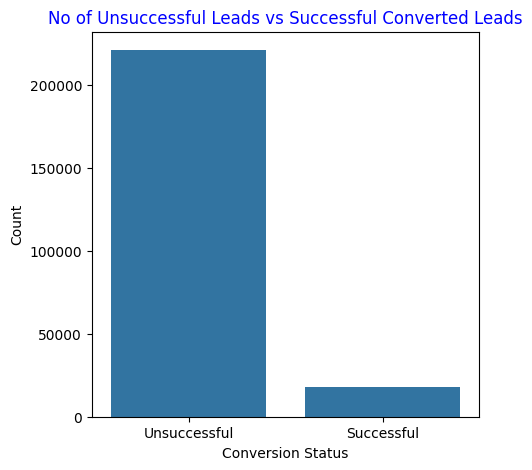

In [32]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_converted', data=df)
plt.title('No of Unsuccessful Leads vs Successful Converted Leads', color='blue')
plt.xticks(np.arange(2), ('Unsuccessful', 'Successful'))
plt.xlabel('Conversion Status')
plt.ylabel('Count')
plt.show()

In [31]:
total_leads = len(df)
successful_leads = df['is_converted'].sum()
conversion_rate = (successful_leads / total_leads) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

Conversion Rate: 7.54%


In [39]:
# Creating a crosstab DataFrame for demonstration
crosstab_df = pd.crosstab(index=df['Lead_Source'], columns='count')

In [62]:

def plot_frequency_and_percentage(feature, df, category_df, another_row=False, height=8, ylabels=[]):
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, height * 2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Get top 5 categories by frequency
    top_categories = category_df[feature].value_counts().nlargest(5).index

    # Frequency plot for top 5 categories
    ax1.set_title(f'Frequency Plot of {feature}', color='blue')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('count')
    sns.countplot(y=feature, data=category_df[category_df[feature].isin(top_categories)],
                  order=top_categories, ax=ax1, color='green')
    if ylabels:
        ax1.set_yticklabels(ylabels)

    # Calculate count of converted leads for top 5 categories
    converted_counts = df[df['is_converted'] == True][feature].value_counts()
    converted_counts = converted_counts[converted_counts.index.isin(top_categories)]

    # Converted leads plot for top 5 categories
    ax2.set_title('Converted Leads Count', color='blue')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('count')
    converted_counts.sort_values().plot(kind='barh', ax=ax2, color='orange')
    if ylabels:
        ax2.set_yticklabels(ylabels)

    # Calculate and display overall conversion rate
    total_leads = len(df)
    successful_leads = df['is_converted'].sum()
    conversion_rate = (successful_leads / total_leads) * 100
    fig.suptitle(f'Overall Conversion Rate: {conversion_rate:.2f}%', fontsize=14, color='red')


plt.show()

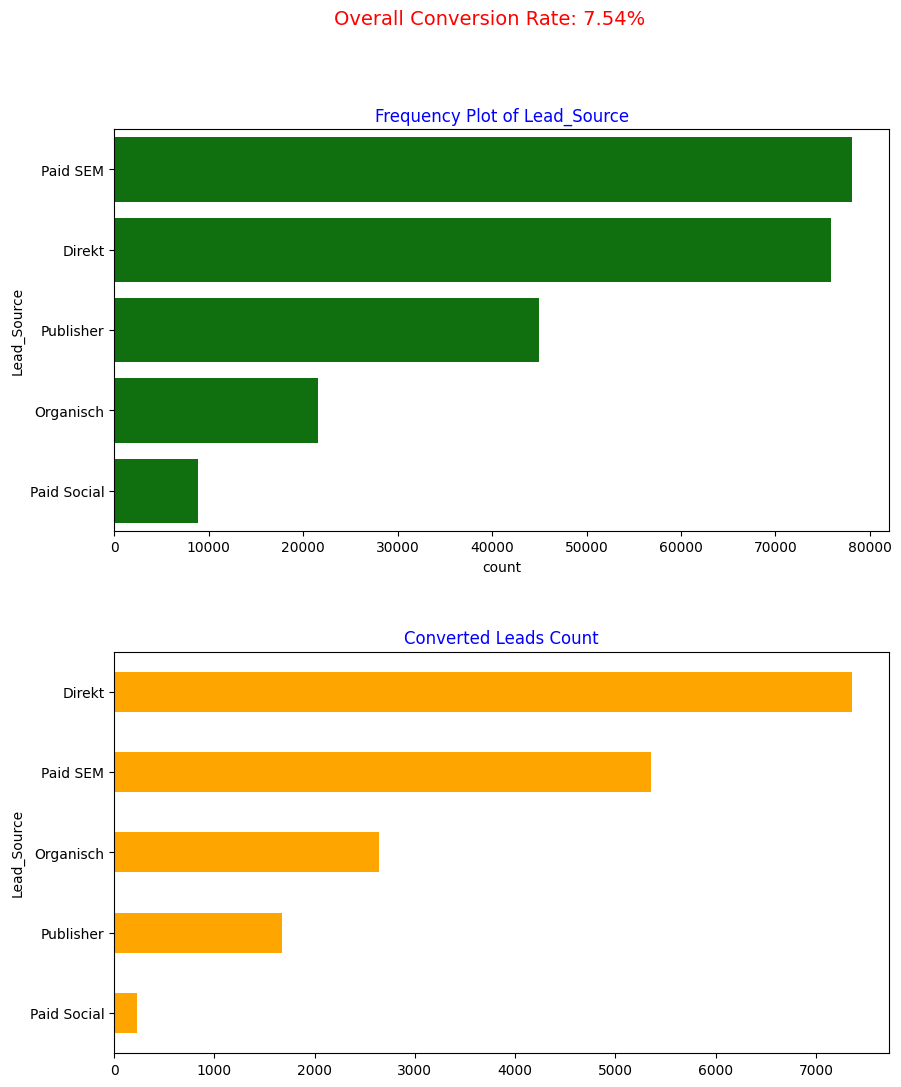

In [63]:
plot_frequency_and_percentage('Lead_Source', df, df, True, 6)

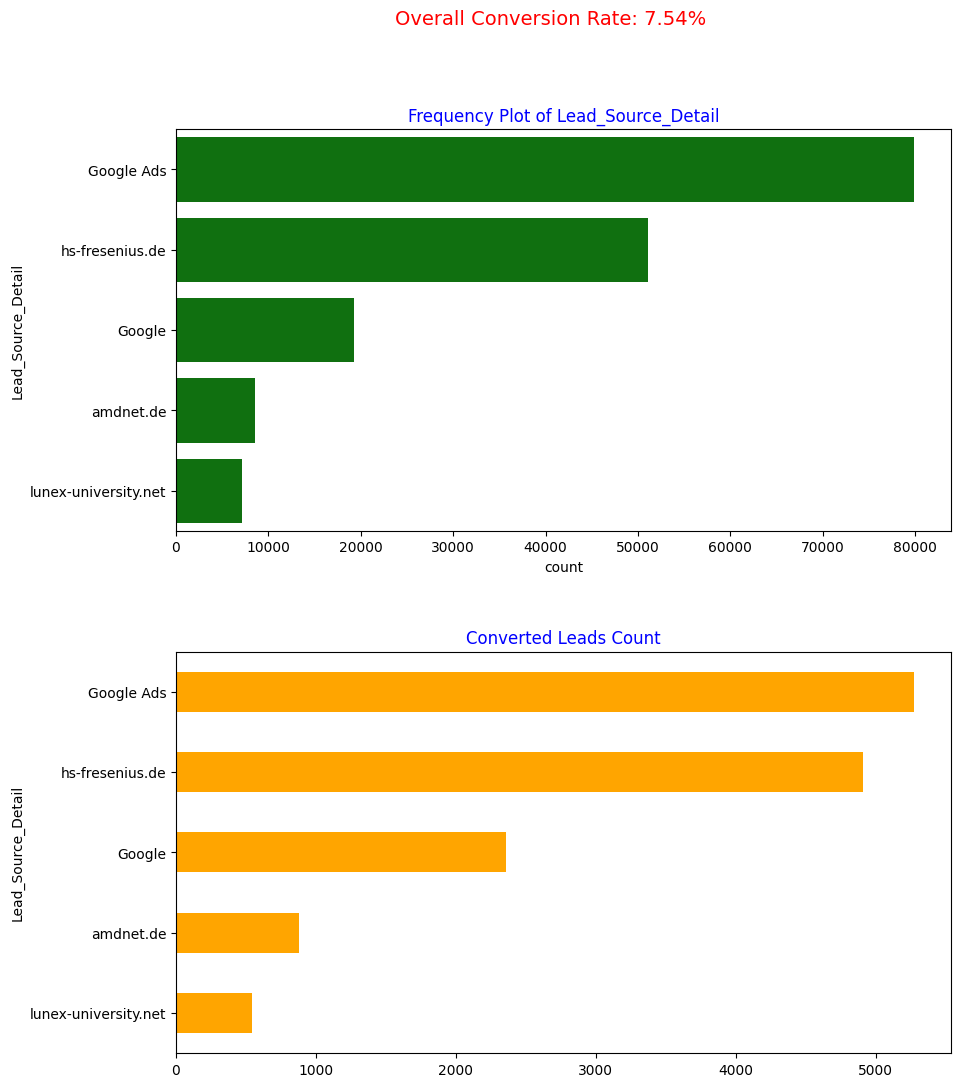

In [65]:
plot_frequency_and_percentage('Lead_Source_Detail', df, df, True, 6)

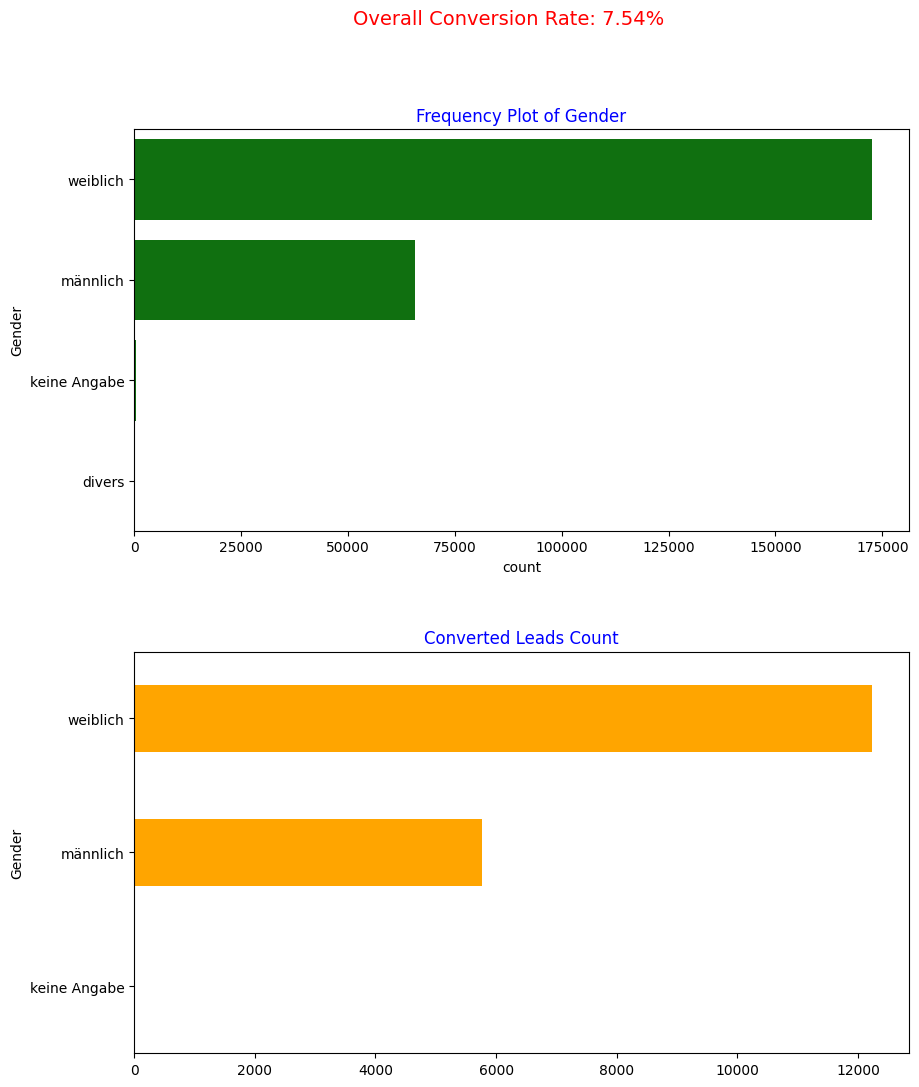

In [66]:
plot_frequency_and_percentage('Gender', df, df, True, 6)

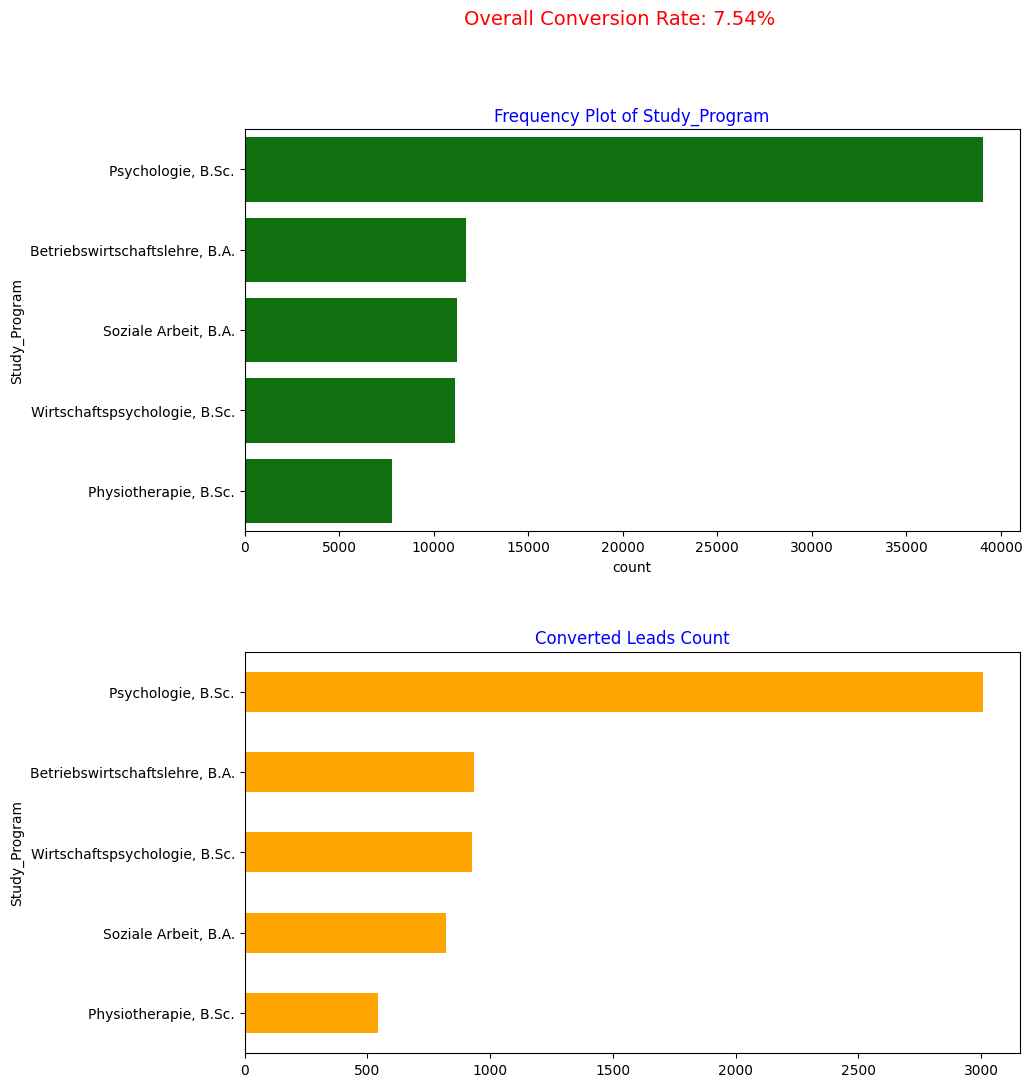

In [67]:
plot_frequency_and_percentage('Study_Program', df, df, True, 6)

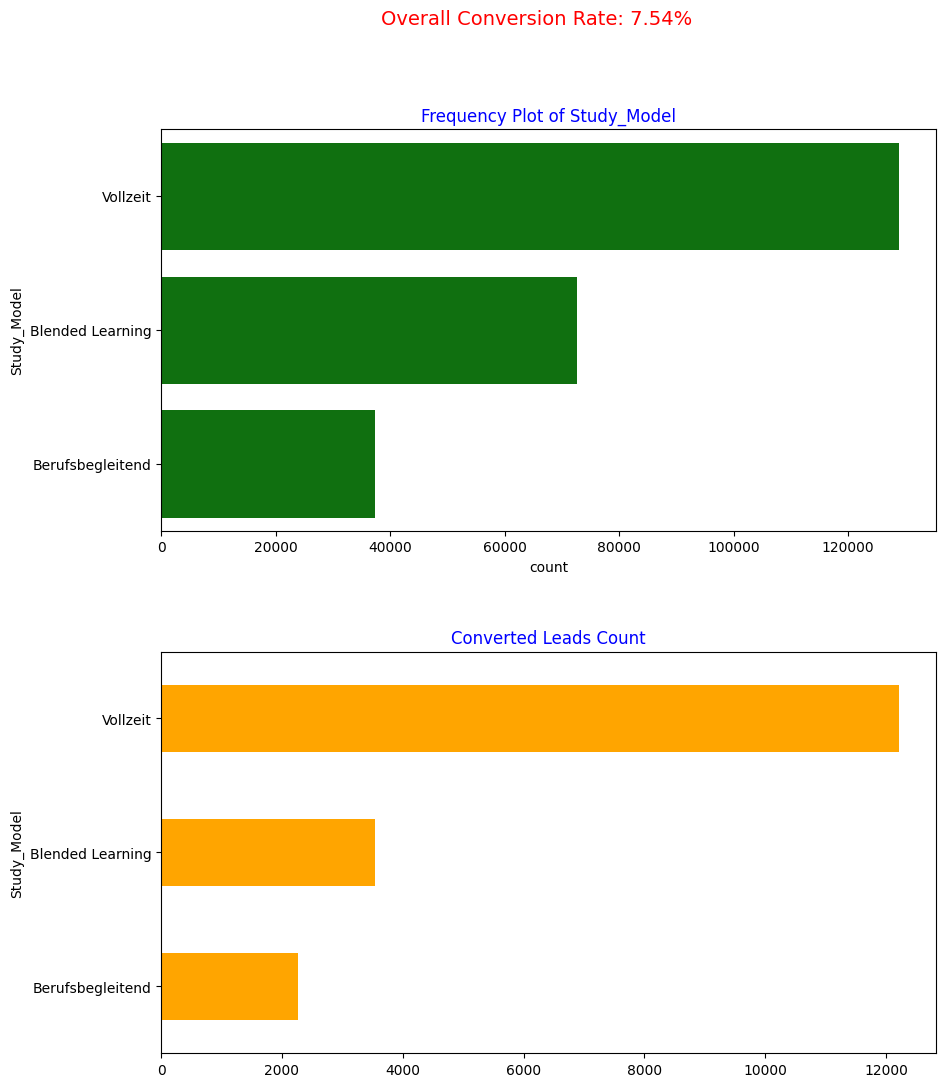

In [72]:
plot_frequency_and_percentage('Study_Model', df, df, True, 6)

In [80]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import category_encoders as ce

In [84]:
df.dtypes

Domain                    object
Name_Describe             object
has_Phone                boolean
Gender                    object
Lead_Source               object
Lead_Source_Detail        object
Study_Model               object
Type_of_Study_Program     object
Conversion_Type           object
Study_Location            object
Faculty                   object
Study_Program             object
Semester                  object
is_converted             boolean
Host                      object
Pagepath                  object
Time_on_Site               Int64
ManualTerm                object
Browser                   object
Operating_System          object
Device                    object
Language                  object
Device_Category           object
ManualAdContent           object
Bounce                    object
dtype: object

In [86]:
df.nunique()

Domain                   11470
Name_Describe                3
has_Phone                    2
Gender                       4
Lead_Source                 26
Lead_Source_Detail         582
Study_Model                  3
Type_of_Study_Program        6
Conversion_Type              2
Study_Location              20
Faculty                     10
Study_Program              219
Semester                     2
is_converted                 2
Host                        18
Pagepath                 48348
Time_on_Site               671
ManualTerm                  16
Browser                      9
Operating_System            69
Device                     193
Language                    36
Device_Category              3
ManualAdContent             47
Bounce                       2
dtype: int64

In [ ]:
# Label Encoding
label_features = ['has_Phone', 'Conversion_Type', 'Semester', 'Bounce']
label_encoder = LabelEncoder()
for col in label_features:
    df[col] = label_encoder.fit_transform(df[col])

# Binary Encoding
binary_features = ['Pagepath', 'Domain']
encoder_binary = ce.BinaryEncoder(cols=binary_features)
df = encoder_binary.fit_transform(df)

# Frequency/Count Encoding
count_features = ['Lead_Source', 'Lead_Source_Detail', 'Study_Location', 'Faculty',
                  'Study_Program', 'Host', 'ManualTerm', 'Operating_System', 'Device',
                  'Language', 'ManualAdContent', 'Name_Describe', 'Gender', 'Study_Model',
                  'Type_of_Study_Program', 'Browser']
for col in count_features:
    count_encoding = df[col].value_counts()
    df[col] = df[col].map(count_encoding)

# Scaling
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns

In [ ]:
categorical_columns = label_features + binary_features
categorical_features = [df.columns.get_loc(col) for col in categorical_columns if col != 'Time_on_Site']

In [76]:
# Load data
X = df.drop(columns=['is_converted'])
y = df['is_converted']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# categorical_features specifies the indices of the categorical columns
smotenc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)